<a href="https://colab.research.google.com/github/nlei1/nlp-notebooks/blob/main/BioWordVec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np, pandas as pd 
import os
import zipfile
import torch
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy import stats
import gensim
import gensim.downloader as api
import seaborn as sns
import matplotlib.pyplot as pyplot
%matplotlib inline

In [5]:
# !wget -P /root/input/ -c 'https://ftp.ncbi.nlm.nih.gov/pub/lu/Suppl/BioSentVec/BioWordVec_PubMed_MIMICIII_d200.vec.bin'

In [6]:
import gensim
# https://github.com/ncbi-nlp/BioSentVec
# Embeddings using PubMed and the clinical notes from MIMIC-III Clinical Database

model = gensim.models.KeyedVectors.load_word2vec_format(
     '/root/input/BioWordVec_PubMed_MIMICIII_d200.vec.bin',
      binary=True,
      limit=int(4E6)
)

In [7]:
url  = 'https://raw.githubusercontent.com/nlei1/csvs-for-proj/main/drugs-side-effects3.csv'
df = pd.read_csv(url, header=None, error_bad_lines=False)
ind_dct = {k: v for v, k in enumerate(df[0].tolist())}

def get_words(drug_name):
  return [incom for incom in df.iloc[ind_dct[drug_name]] if str(incom) != 'nan']

def get_embeddings(words_lst):
  # takes in a name and returns a lst of embeddings of drug and its related words
  embeddings = []
  for item in words_lst:
    embeddings.append(model[item])
  return embeddings

def get_pca(embeddings, n_components):
  pca = PCA(n_components)
  pca_result = pca.fit_transform(embeddings)
  post_pca = pd.DataFrame(pca_result, columns = ['x','y'])
  return post_pca

def get_tsne(embeddings, p_perplexity, p_n_iter, n_components):
  tsne = TSNE(n_components, perplexity=p_perplexity, n_iter=p_n_iter)
  tsne_result = tsne.fit_transform(embeddings)
  post_tsne = pd.DataFrame(tsne_result, columns = ['x','y'])
  return post_tsne

def plot_with_labels(drug_name, pca=True, p_perplexity=1, p_n_iter=1000, n_components=2):
  words_lst = get_words(drug_name)
  embeddings_lst = get_embeddings(words_lst)
  if pca:
    post_reduction = get_pca(embeddings_lst, n_components)
  else:
    post_reduction = get_tsne(embeddings_lst, p_perplexity, p_n_iter, n_components)
  post_reduction_annotated = post_reduction.join(pd.DataFrame(words_lst, columns=['label']))
  ax = post_reduction_annotated.plot(x='x',y='y',kind='scatter',figsize=(10,10))
  post_reduction_annotated[['x','y','label']].apply(lambda x: ax.text(*x),axis=1)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


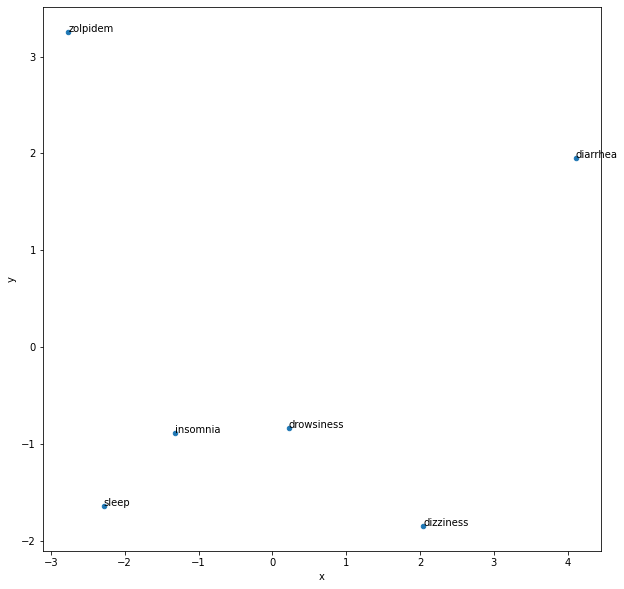

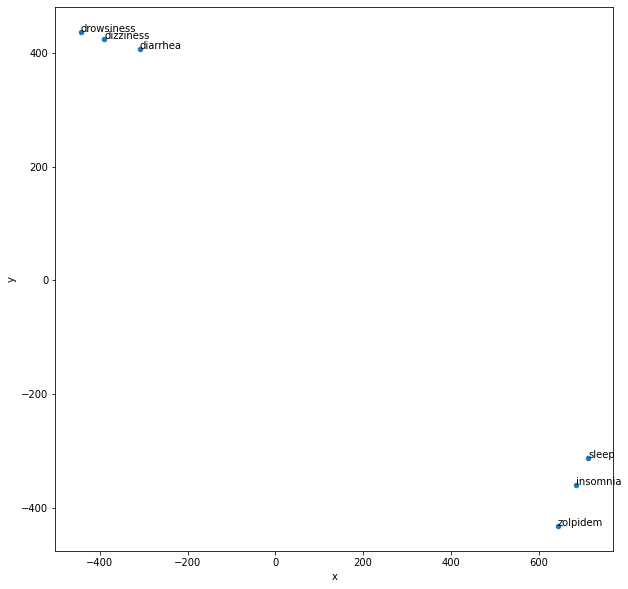

In [8]:
plot_with_labels('zolpidem')
plot_with_labels('zolpidem', False)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


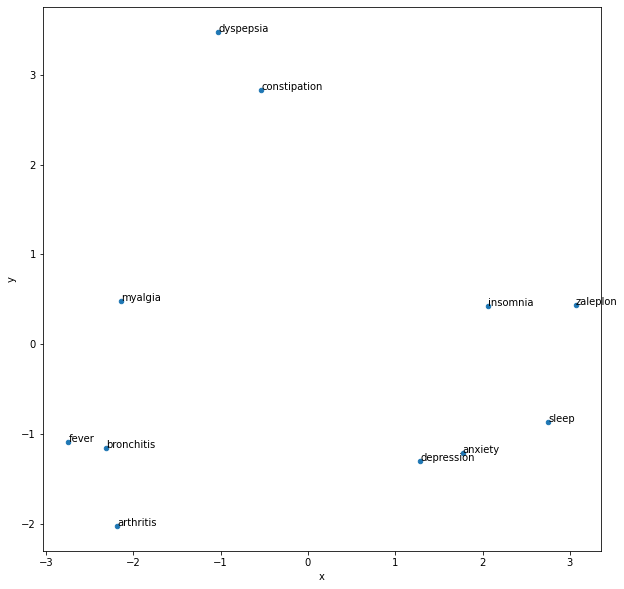

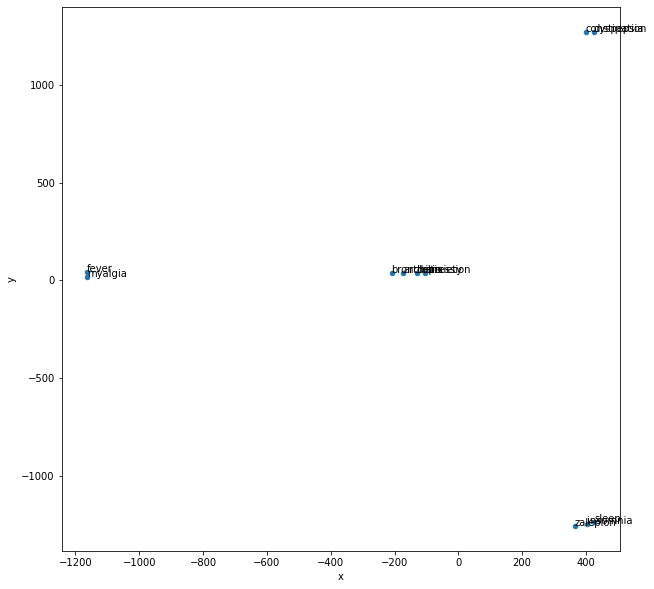

In [9]:
plot_with_labels('zaleplon')
plot_with_labels('zaleplon', False)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


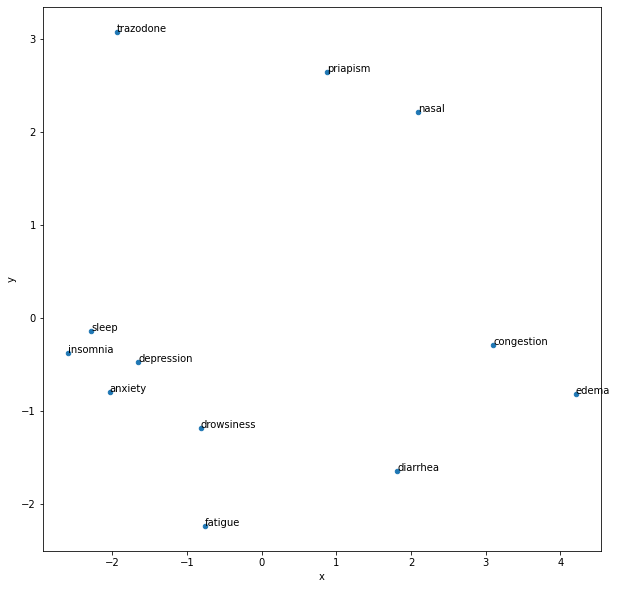

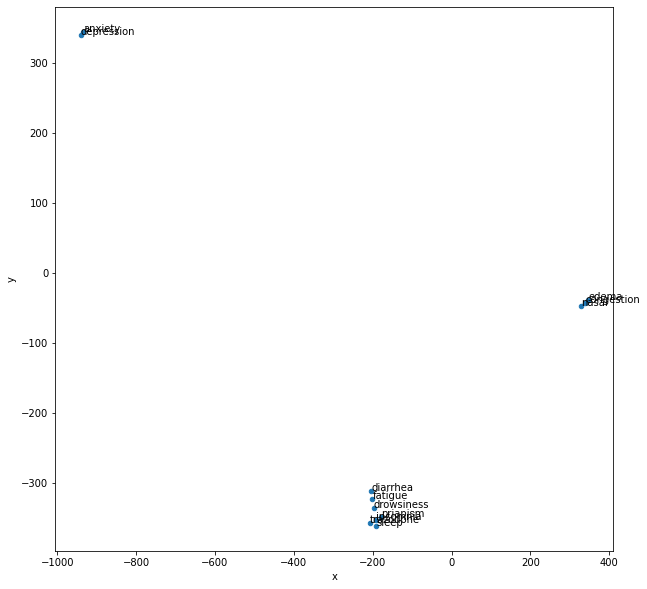

In [10]:
plot_with_labels('trazodone')
plot_with_labels('trazodone', False)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


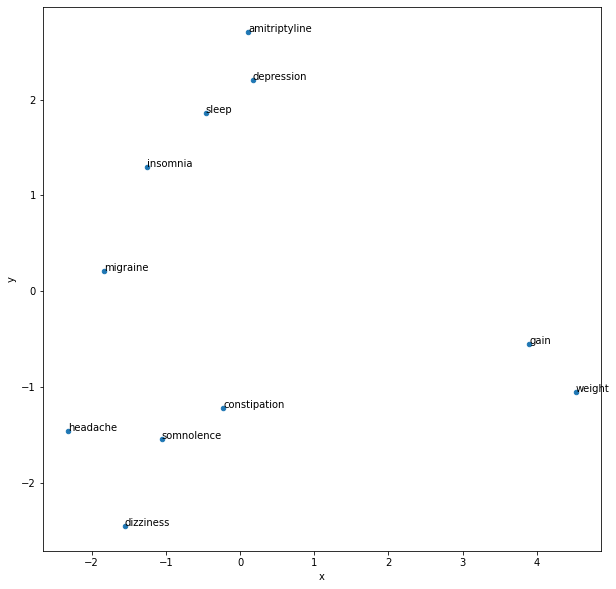

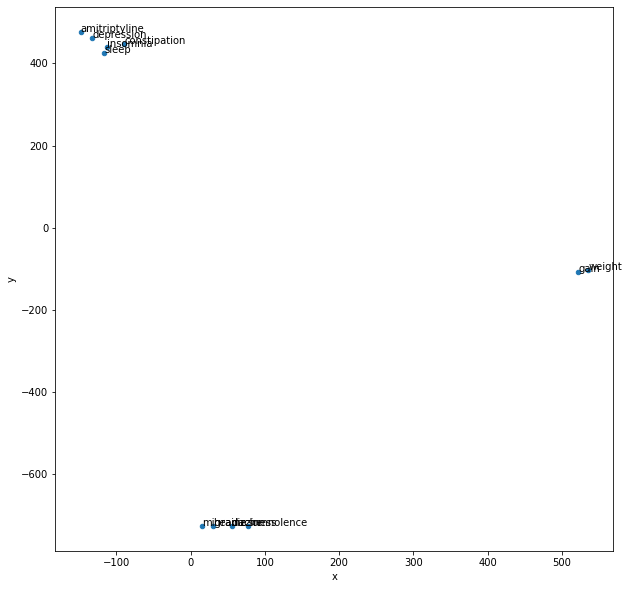

In [11]:
plot_with_labels('amitriptyline')
plot_with_labels('amitriptyline', False)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


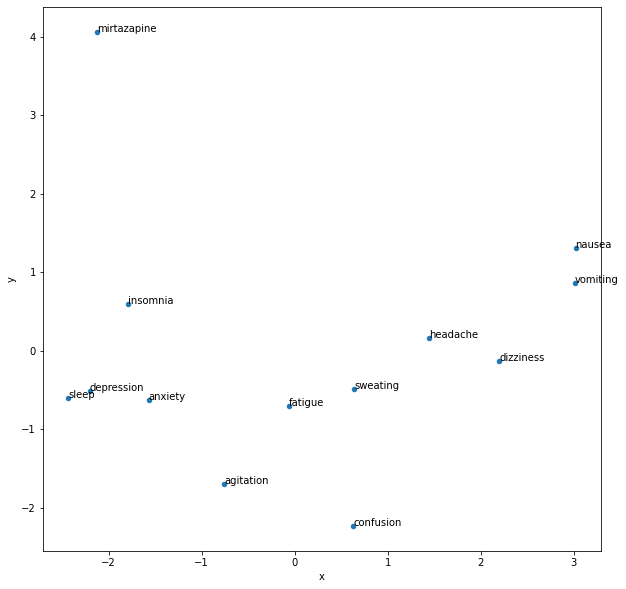

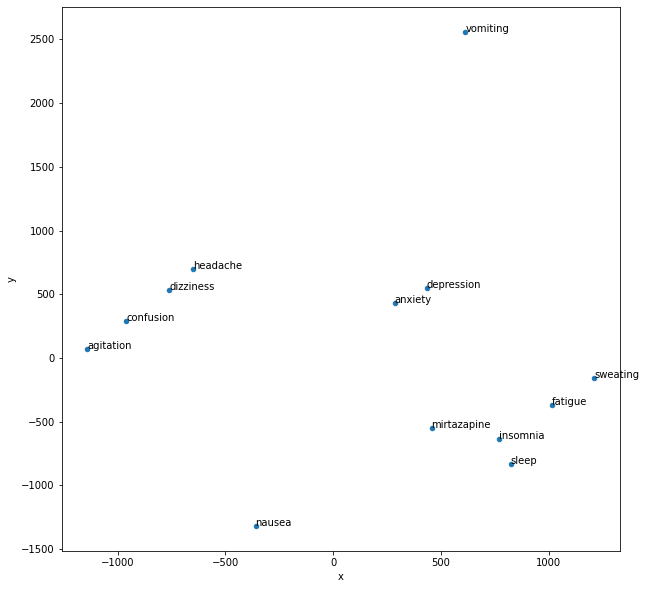

In [12]:
plot_with_labels('mirtazapine')
plot_with_labels('mirtazapine', False)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


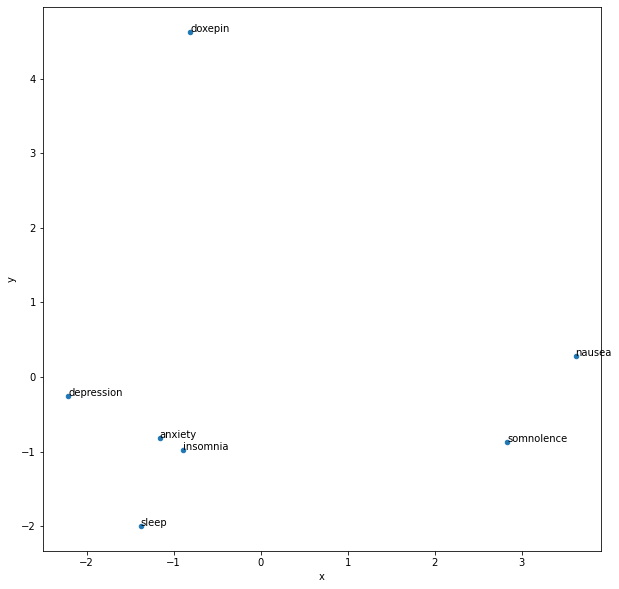

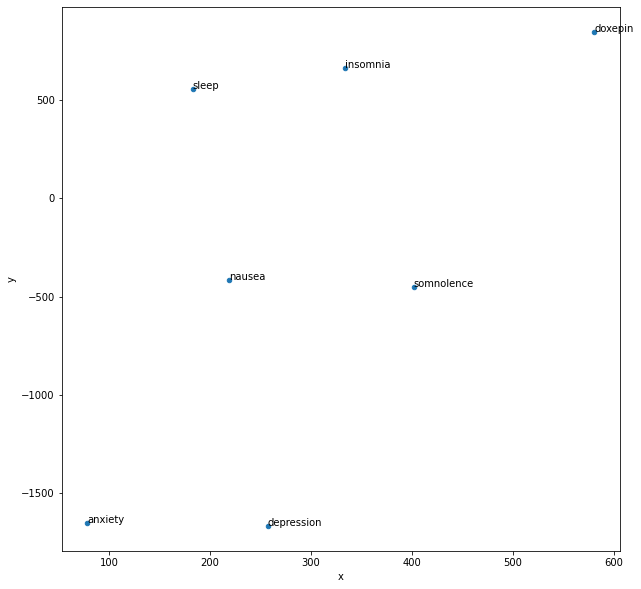

In [13]:
plot_with_labels('doxepin')
plot_with_labels('doxepin', False)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


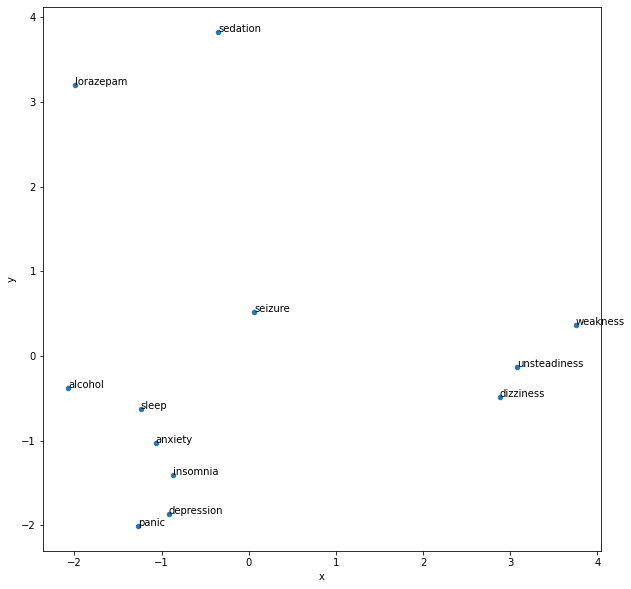

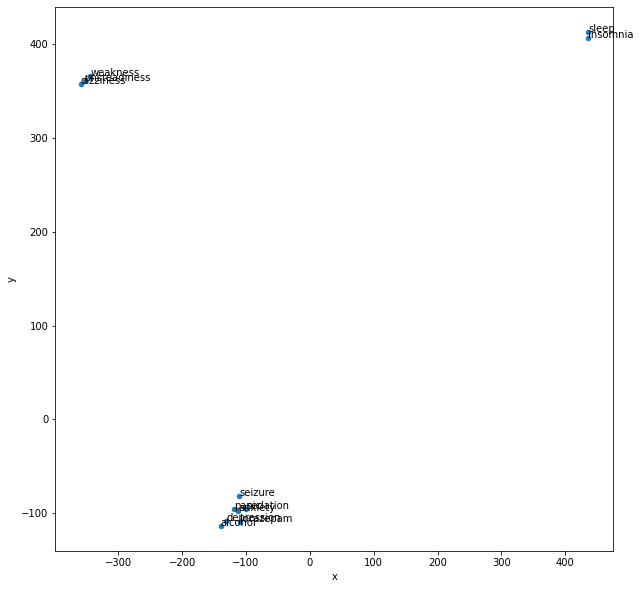

In [14]:
plot_with_labels('lorazepam')
plot_with_labels('lorazepam', False)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


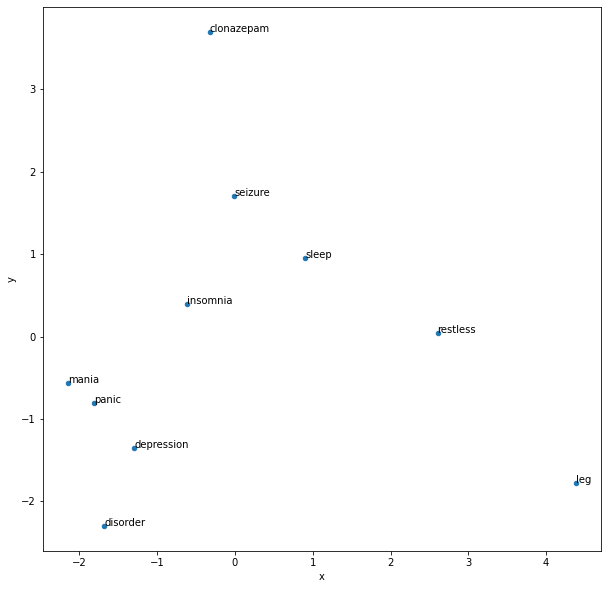

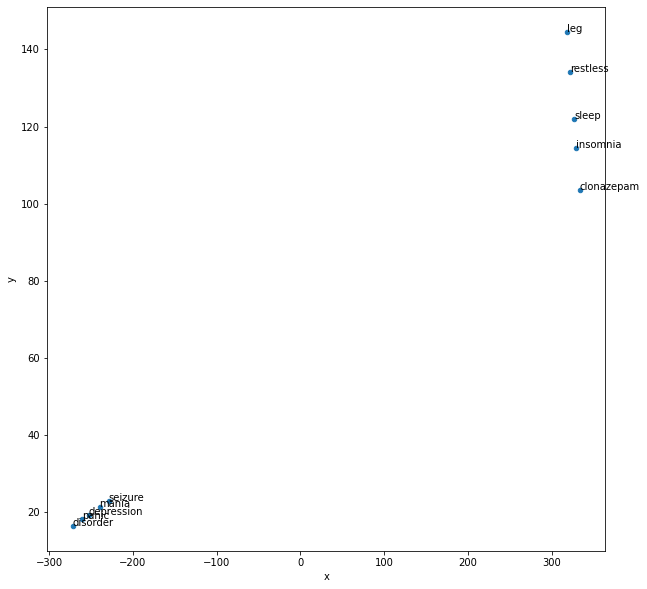

In [15]:
plot_with_labels('clonazepam')
plot_with_labels('clonazepam', False)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


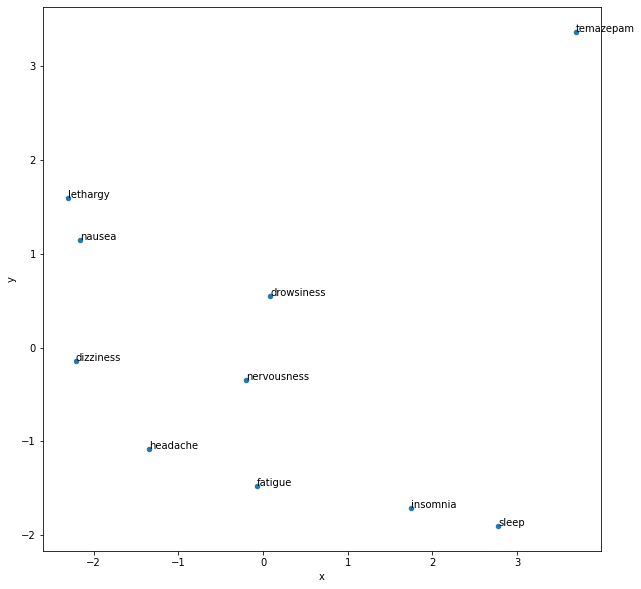

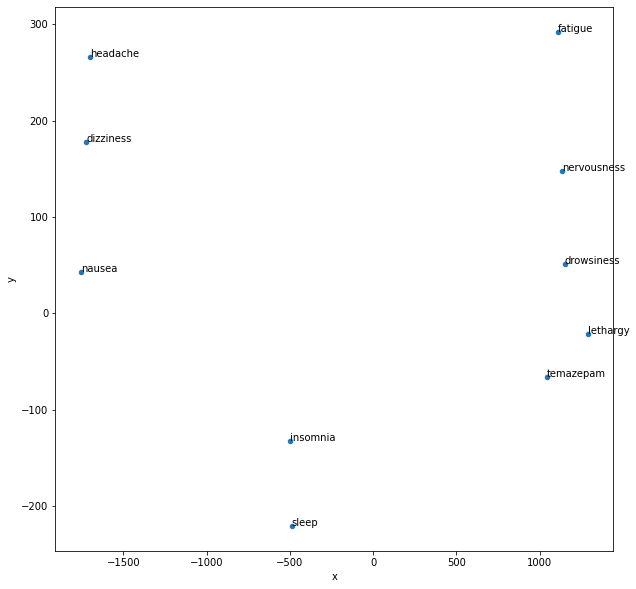

In [16]:
plot_with_labels('temazepam')
plot_with_labels('temazepam', False)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


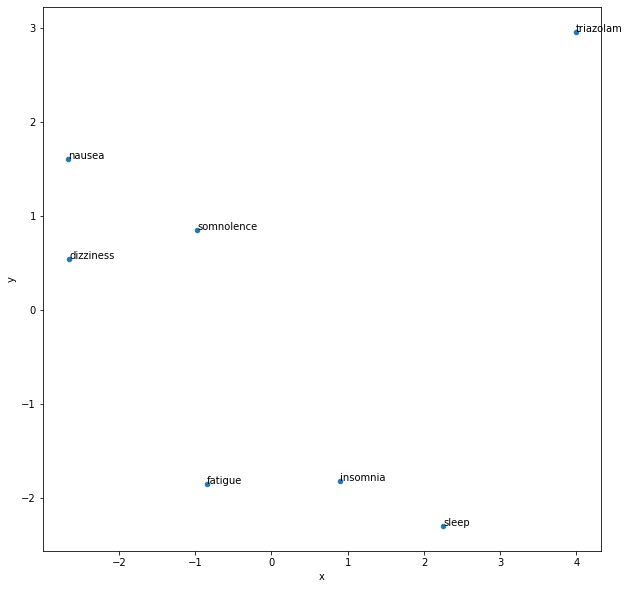

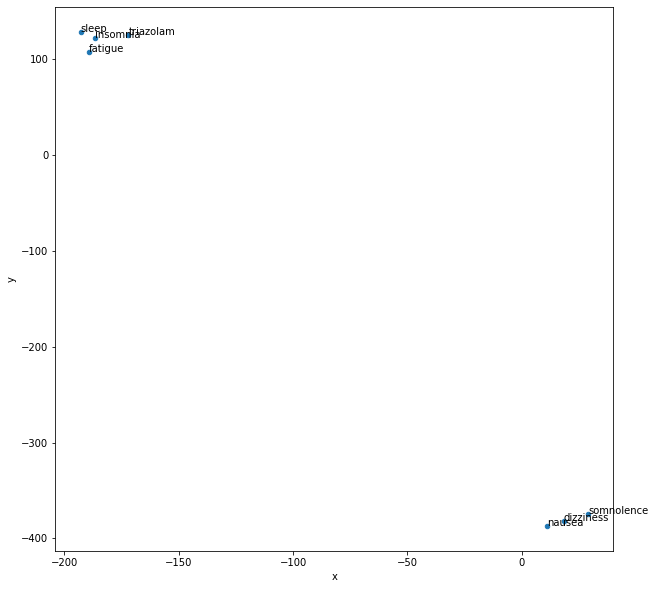

In [17]:
plot_with_labels('triazolam')
plot_with_labels('triazolam', False)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


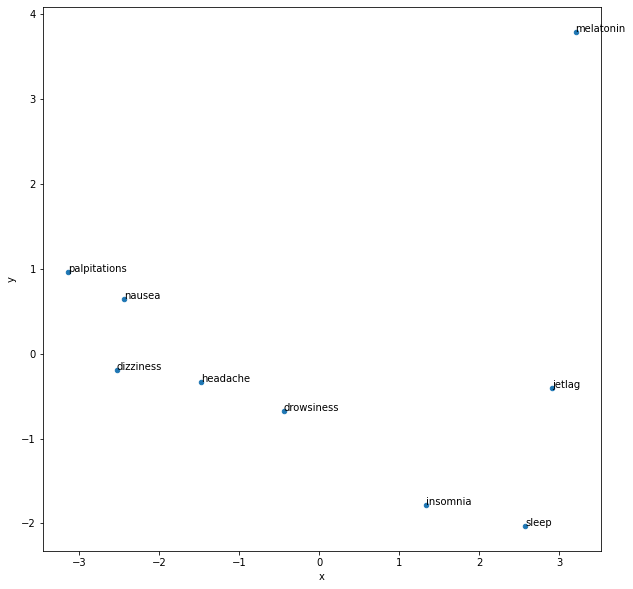

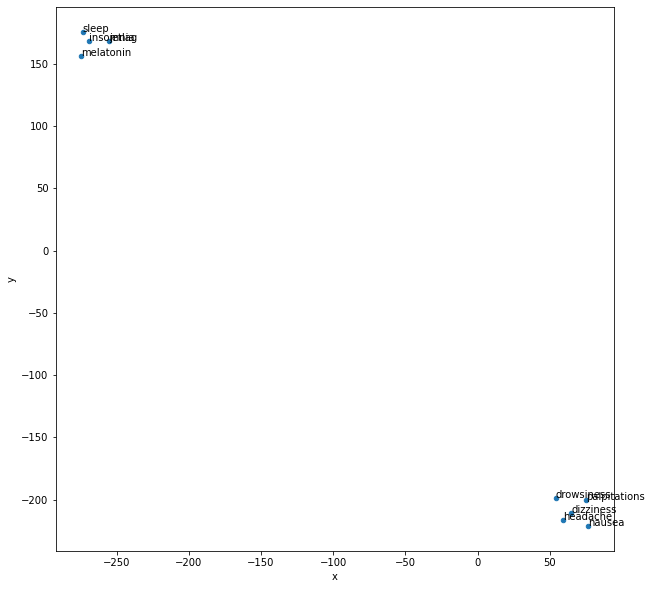

In [18]:
plot_with_labels('melatonin')
plot_with_labels('melatonin', False)

0     Text(-2.125305599676706, -0.021582376739308094...
1     Text(-1.3618271753290463, 0.5883204736175811, ...
2     Text(-2.0427269983823653, 1.0108660645496474, ...
3     Text(-1.3895076099861319, -0.655327142414519, ...
4     Text(-0.49365997203242806, -0.4915797600830818...
5     Text(-1.0822071507006497, -0.8520175875189886,...
6     Text(-1.0107045483272832, -0.35561553362141907...
7     Text(-1.9706407126406478, -1.822172646426965, ...
8     Text(-1.8971521708116512, -0.805015388567089, ...
9     Text(-2.0384252721799427, -0.5815017141159743,...
10    Text(-2.200418059771709, 0.7998772966059886, '...
11    Text(0.08060623651156272, 4.381455669508034, '...
12    Text(3.6049490773954926, -0.8600556552468432, ...
13    Text(3.6049490773954926, -0.8600556552468432, ...
14    Text(3.513639020442423, 0.3476626083312874, 'f...
15    Text(3.289169440603401, 0.6678982389885691, 'l...
16    Text(3.519262417490187, -0.49115689162007714, ...
dtype: object

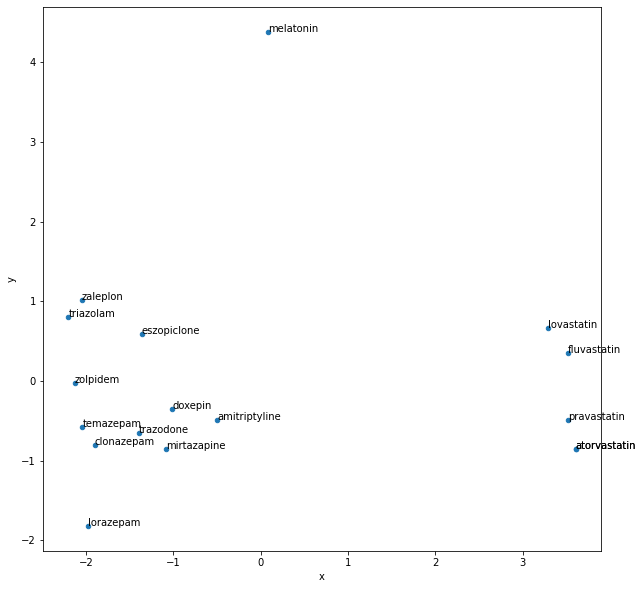

In [19]:
words_lst = df[0].tolist() + ['atorvastatin', 'fluvastatin', 'lovastatin', 'pravastatin']
embeddings_lst = get_embeddings(words_lst)
post_reduction = get_pca(embeddings_lst, n_components=2)
post_reduction_annotated = post_reduction.join(pd.DataFrame(words_lst, columns=['label']))
ax = post_reduction_annotated.plot(x='x',y='y',kind='scatter',figsize=(10,10))
post_reduction_annotated[['x','y','label']].apply(lambda x: ax.text(*x),axis=1)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


0     Text(-8.160855293273926, -63.542137145996094, ...
1     Text(26.30388069152832, 8.268622398376465, 'es...
2     Text(5.622807025909424, -35.027164459228516, '...
3     Text(-337.9043273925781, 63.39997482299805, 't...
4     Text(29.62566566467285, 377.3013000488281, 'am...
5     Text(-318.237060546875, 39.79179000854492, 'mi...
6     Text(-0.2274128794670105, 387.8973083496094, '...
7     Text(-271.0555114746094, -289.0568542480469, '...
8     Text(-301.8056945800781, -286.010498046875, 'c...
9     Text(387.5661315917969, -381.98004150390625, '...
10    Text(431.71343994140625, -382.9825744628906, '...
11    Text(74.88790130615234, 361.3118896484375, 'me...
12    Text(-868.3304443359375, 233.88856506347656, '...
13    Text(-893.17041015625, 215.80706787109375, 'at...
14    Text(234.7364501953125, -233.068603515625, 'fl...
15    Text(210.72219848632812, -274.7214050292969, '...
16    Text(250.51683044433594, -205.57778930664062, ...
dtype: object

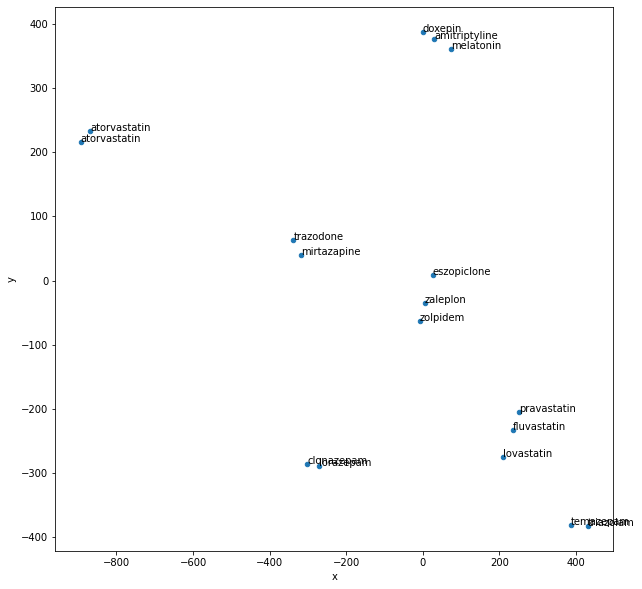

In [20]:
words_lst = df[0].tolist() + ['atorvastatin', 'fluvastatin', 'lovastatin', 'pravastatin']
embeddings_lst = get_embeddings(words_lst)
post_reduction = get_tsne(embeddings_lst, p_perplexity=1, p_n_iter=1000, n_components=2)
post_reduction_annotated = post_reduction.join(pd.DataFrame(words_lst, columns=['label']))
ax = post_reduction_annotated.plot(x='x',y='y',kind='scatter',figsize=(10,10))
post_reduction_annotated[['x','y','label']].apply(lambda x: ax.text(*x),axis=1)